In [1]:
# Setup of libraries, mounting the Google Drive etc.

import os
import sys
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf

import utils
import IPython

print('The current working directory is:', os.getcwd())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
The current working directory is: /content/gdrive/My Drive/Colab Notebooks


## Define the parameters
... meaning paramters like which dataset to train on, batch size and so on and so forth

In [0]:
DATASET_NAME = 'mdc'

setup_string = 'GRU-1024_TD-Dense-3_{dataset}_64_100_adam_mae_default'.format(dataset=DATASET_NAME)

## Read the dataset from `.pkl` file


In [3]:
df = pd.read_pickle('datasets/{name}.pkl'.format(name=DATASET_NAME))
df.head()

latitude  longitude  time_zone type
user time                                                    
5448 2009-10-31 15:55:40  6.632476  46.520321      -7200  gps
     2009-10-31 16:34:37  6.592562  46.523943      -7200  gps
     2009-10-31 16:34:46  6.594179  46.524187      -7200  gps
     2009-10-31 16:34:46  6.594179  46.524187      -7200  gps
     2009-10-31 16:34:57  6.596068  46.523909      -7200  gps

## Convert the dataset to a mapping of users to the strings of their movements

In [4]:
df = utils.records_to_user_geolcation(df)
df.head()

user
5448    [[5221507.0, 46.520321080100004, 6.63247568099...
5449    [[6511.0, 46.516730358000004, 6.49393829669000...
5450    [[1159812.0, 46.51, 6.56], [1160142.0, 46.51, ...
5451    [[0.0, 46.521, 6.621], [0.0, 46.521, 6.621], [...
5462    [[1142534.0, 46.52, 6.564], [1142544.0, 46.52,...
dtype: object

## Concatenate all user strings of data to one complete string of all

In [5]:
data = utils.user_geolocation_to_single_sequence(df)

print(data.shape)
print()
print(data)

(13678618, 3)

[[5.22150700e+06 4.65203211e+01 6.63247568e+00]
 [5.22384400e+06 4.65239433e+01 6.59256200e+00]
 [5.22385300e+06 4.65241869e+01 6.59417870e+00]
 ...
 [3.36339640e+07 4.66735664e+01 6.59025320e+00]
 [3.36339740e+07 4.66735871e+01 6.59024306e+00]
 [3.36339840e+07 4.66736894e+01 6.59020584e+00]]


## Convert the data to 32-bit floats
This is to correct an error I got earlier. Apparently the GRU layers can't handle 64-bit integers (doubles) as input.

In [6]:
print('Before: ', data.dtype)

Before:  float64


In [0]:
data = data.astype(np.float32)

In [8]:
print('After: ', data.dtype)

After:  float32


## Reshape and -order the data for input into the model (including X and y split)


In [9]:
data.shape

(13678618, 3)

In [10]:
BATCH_SIZE = 64
SEQ_LENGTH = 100

n_batches, X, y = utils.reshape_single_sequence_to_rnn_Xy(data, BATCH_SIZE, SEQ_LENGTH)

print('X:', X.shape)
print('y:', y.shape)

X: (136768, 100, 3)
y: (136768, 100, 3)


## Split into training and validations sets

In [11]:
n_train = int(n_batches * 0.8) * BATCH_SIZE
X_train = X[:n_train]
y_train = y[:n_train]
X_val = X[n_train:]
y_val = y[n_train:]

print('Train:', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)

Train: (109376, 100, 3) (109376, 100, 3)
Validation: (27392, 100, 3) (27392, 100, 3)


## Standardisation
All three features in the data are scaled to have a `mean = 0` and a `standard deviation = 1`.

The Scaler is also saved to disk, so it can later be resued in a different Notebook.

The Scaler is fitted only to the training data, not the validation / test data.

In [12]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(np.array([X_train[:, :, 0].reshape(-1), X_train[:, :, 1].reshape(-1), X_train[:, :, 2].reshape(-1)]).transpose())

print('Means: %f %f %f' % (scaler.mean_[0], scaler.mean_[1], scaler.mean_[2]))
print('Standard deviations: %f %f %f' % (scaler.var_[0], scaler.var_[1], scaler.var_[2]))

Means: 23706651.346612 46.436004 6.887024
Standard deviations: 142654134288384.000000 0.059310 0.203860


In [13]:
with open('scalers/citybased_rnn/' + setup_string + '.pkl', 'wb') as file:
    pickle.dump(scaler, file)
    print('Scaler saved')

Scaler saved


In [0]:
for i in range(len(X_train)):
    X_train[i] = scaler.transform(X_train[i])
    y_train[i] = scaler.transform(y_train[i])

for i in range(len(X_val)):
    X_val[i] = scaler.transform(X_val[i])
    y_val[i] = scaler.transform(y_val[i])

In [15]:
print(X_train.shape)
print()
print(X_train[:1, :6])
print(X_val[:1, :6])

(109376, 100, 3)

[[[-1.5476781   0.34622005 -0.5637724 ]
  [-1.5474826   0.36110058 -0.65217304]
  [-1.5474818   0.3620874  -0.6485929 ]
  [-1.5474818   0.3620874  -0.6485929 ]
  [-1.547481    0.3609596  -0.6444076 ]
  [-1.547481    0.3609596  -0.6444076 ]]]
[[[-1.6141281   0.34490427 -0.7132176 ]
  [-1.61322     0.34490427 -0.711003  ]
  [-1.6132191   0.34490427 -0.711003  ]
  [-1.6132183   0.34490427 -0.7132176 ]
  [-1.6132175   0.34490427 -0.711003  ]
  [-1.6130643   0.35066852 -0.70833   ]]]


## Build the model

In [0]:
def build_model(batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(1024, return_sequences=True, stateful=True, input_shape=(None, 3), batch_size=batch_size),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3))
    ])
    return model

In [17]:
model = build_model(batch_size=BATCH_SIZE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (64, None, 1024)          3158016   
_________________________________________________________________
time_distributed (TimeDistri (64, None, 3)             3075      
Total params: 3,161,091
Trainable params: 3,161,091
Non-trainable params: 0
_________________________________________________________________


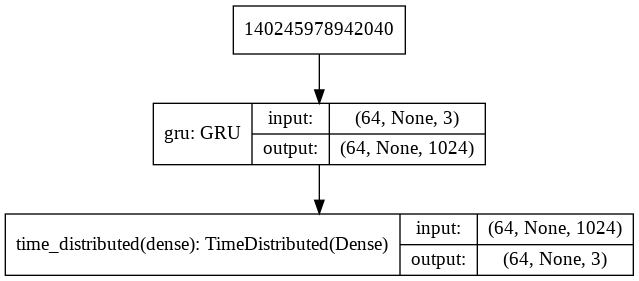

In [18]:
tf.keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

## Test the model's output (before training)

In [19]:
model.input

<tf.Tensor 'gru_input:0' shape=(64, ?, 3) dtype=float32>

In [20]:
# Test the shape of the output
test_batch = X[:BATCH_SIZE]
print('Input batch:', test_batch.shape)
test_predictions = model.predict(test_batch, batch_size=BATCH_SIZE)

print('Output batch:', test_predictions.shape)

model.reset_states()

Input batch: (64, 100, 3)
Output batch: (64, 100, 3)


In [0]:
test_batch = scaler.inverse_transform(test_batch)
test_predictions = scaler.inverse_transform(test_predictions)

In [22]:
print('Input: \n', test_batch[0, 0], test_batch[0, 1], test_batch[0, 2], '...')
print()
print('Next Predictions: \n', test_predictions[0, 0], test_predictions[0, 1], test_predictions[0, 2], '...')

Input: 
 [5.2215075e+06 4.6520321e+01 6.6324759e+00] [5.2238435e+06 4.6523945e+01 6.5925622e+00] [5.2238535e+06 4.6524185e+01 6.5941787e+00] ...

Next Predictions: 
 [2.3591860e+07 4.6433022e+01 6.8742285e+00] [2.3600062e+07 4.6431149e+01 6.8703837e+00] [2.3612056e+07 4.6430153e+01 6.8691864e+00] ...


## Training

In [0]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [0]:
# Folder for the architecture
# Name: List of the layers connected to the parameters by '-',
#       dataset that the network was trained on,
#       batch size,
#       sequence length,
#       optimiser,
#       loss function,
#       learning rate,
#       epoch the checkpoint is from
checkpoint_path = 'checkpoints/citybased_rnn/' + setup_string + '_{epoch:02d}.h5'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path)

In [0]:
hist = model.fit(X_train, y_train, epochs=30, batch_size=BATCH_SIZE, shuffle=False, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Train on 109376 samples, validate on 27392 samples
Epoch 1/30
 43520/109376 [==========>...................] - ETA: 6:08 - loss: 0.0182

## Save and plot the history
The history holds information on loss and validiation loss during training.

In [0]:
with open('histories/citybased_rnn/' + setup_string + '_30.pkl', 'wb') as file:
    pickle.dump(hist.history, file)
    print('History saved')

In [0]:
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

## Load and prepare the trained model for generating data

In [0]:
loaded_model = tf.keras.models.load_model('checkpoints/citybased_rnn/GRU-1024_TD-Dense-3_cabspotting_64_100_adam_mae_default_05.h5')

In [0]:
model = build_model(batch_size=1)

weights = loaded_model.get_weights()
model.set_weights(weights)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (1, None, 1024)           3158016   
_________________________________________________________________
time_distributed_1 (TimeDist (1, None, 3)              3075      
Total params: 3,161,091
Trainable params: 3,161,091
Non-trainable params: 0
_________________________________________________________________


## Generate geolocation data of one entity using the trained model
In the end the generated data is saved to disk in order to be reused from a different notebook.

In [0]:
N_GENERATE = 1000

start = [324.0, -122.390085, 37.789910]    # Google Offices in San Francisco: 37.789910, -122.390085
generated = np.array([start]).astype(np.float32)

model.reset_states()

for i in range(1, N_GENERATE):
    input = generated[-1:]
    input = scaler.transform(input)
    input = np.array([input])
    
    prediction = model.predict(input, batch_size=1)
    
    prediction = np.squeeze(prediction, axis=0)
    prediction = scaler.inverse_transform(prediction)
    
    generated = np.concatenate([generated, prediction])

In [0]:
generated.shape

(1000, 3)

In [0]:
generated

array([[ 3.24000000e+02, -1.22390083e+02,  3.77899094e+01],
       [-3.02492656e+04, -1.22387428e+02,  3.77959785e+01],
       [-5.41318281e+04, -1.22385445e+02,  3.78016281e+01],
       ...,
       [-1.29628850e+06, -1.22439728e+02,  3.76924286e+01],
       [-1.29628400e+06, -1.22439728e+02,  3.76924057e+01],
       [-1.29627975e+06, -1.22439728e+02,  3.76923828e+01]], dtype=float32)

In [0]:
with open('generated/citybased_rnn/test_00.pkl', 'wb') as file:
    pickle.dump(generated, file)
    print('Generated data saved')

Generated data saved
